## Геолокация терминала

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from typing import Tuple, Callable
%matplotlib inline

In [2]:
data_path = 'terminals_geo'

train_df = pd.read_csv(os.path.join(data_path, 'train_points.csv'))
test_df = pd.read_csv(os.path.join(data_path, 'test_points_hidden.csv'))
txn_df = pd.read_csv(os.path.join(data_path, 'point_transactions.csv'))

In [3]:
# координаты Москвы
moscow_lat = 55.451332
moscow_lon = 37.369336

# границы РФ
lat_min, lat_max, lon_min, lon_max = 41.1850968, 82.0586232, 19.6389, 170

In [4]:
def scatter_data():
    tmp = txn_df.join(train_df, on='ID_MERCH', how='left', rsuffix='m')

    plt.figure(figsize=(16, 10))
    
    plt.subplot(2, 1, 1)

    df = tmp[tmp.ID_MERCHm.notna()]
    plt.scatter(df.LON, df.LAT, alpha=0.4, label=f'txn ({df.shape[0]//1e3:.0f} K)', color='lightblue')
    plt.scatter(train_df.LON, train_df.LAT, alpha=0.7, label=f'terminal ({train_df.shape[0]})', 
                color='orange', marker='+', s=100)
    plt.plot(moscow_lon, moscow_lat, 'rx')
    plt.legend()
    plt.title('train')
    plt.xlim(lon_min-5, lon_max+5)
    plt.ylim(lat_min-5, lat_max+5)
    
    plt.subplot(2, 1, 2)
    plt.title('test')

    df = tmp[tmp.ID_MERCHm.isna()]
    plt.scatter(df.LON, df.LAT, alpha=0.4, label=f'txn ({df.shape[0]//1e3:.0f} K)', color='lightblue')
    plt.plot(moscow_lon, moscow_lat, 'rx')
    plt.legend()
    plt.xlim(lon_min-5, lon_max+5)
    plt.ylim(lat_min-5, lat_max+5)
    
    plt.show()

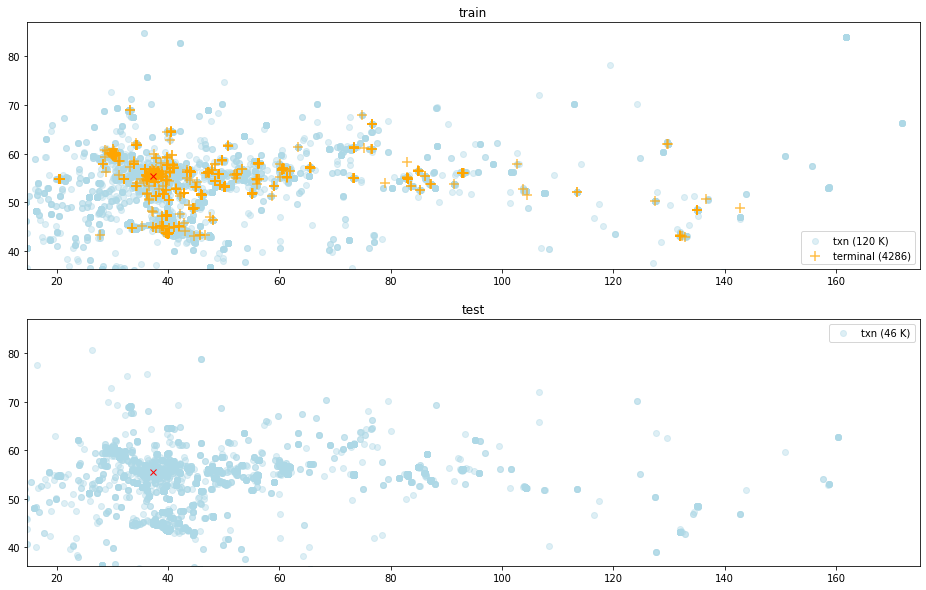

In [5]:
scatter_data()

### Координаты за пределами России

In [6]:
merch_outside_rus = (~train_df.LAT.between(lat_min, lat_max) | ~train_df.LON.between(lon_min, lon_max)).mean()
print(f"терминалов за пределами России: {merch_outside_rus}")

терминалов за пределами России: 0.0


In [7]:
txn_outside_rus = (~txn_df.LAT.between(lat_min, lat_max) | ~txn_df.LON.between(lon_min, lon_max)).mean()
print(f"транзакций за пределами России: {txn_outside_rus:.1%}")

транзакций за пределами России: 14.5%


Все терминалы train-сета лежат в bounding box'е РФ. Исходя из этого и из scatter плота, считаем, что все транзакции должны происходить также в РФ.

В заметной доле транзакций координаты лежат за пределами РФ. Будем считать, что это неудачная геолокация, и выкинем эти транзакции.

In [8]:
init_txn_cnt = txn_df.shape[0]
txn_df = txn_df.drop(
    txn_df[
        ~txn_df.LAT.between(lat_min, lat_max) | ~txn_df.LON.between(lon_min, lon_max)
    ].index
)

In [9]:
print(f'осталось {txn_df.shape[0]/init_txn_cnt:.1%} транзакций')

осталось 85.5% транзакций


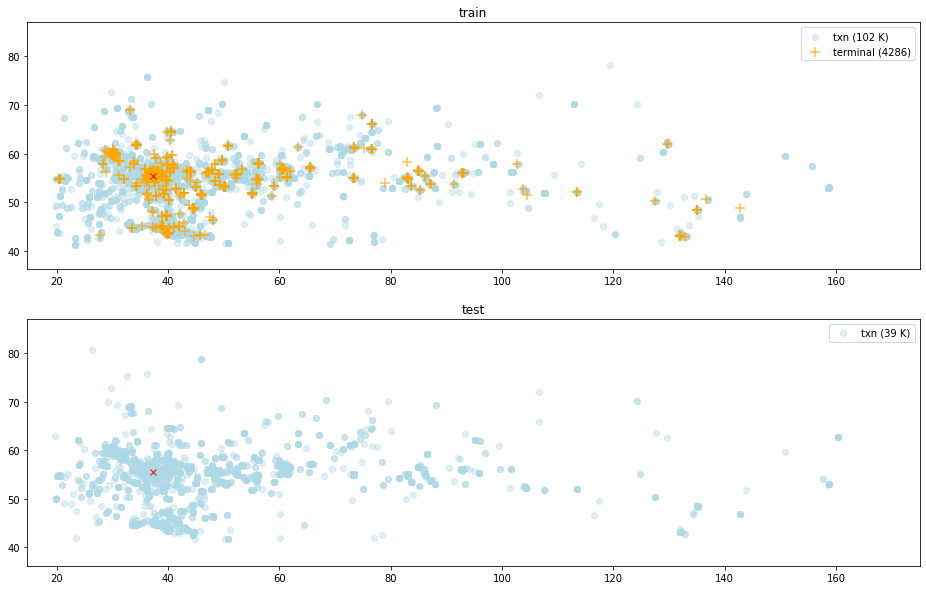

In [10]:
scatter_data()

### Нахождение терминала по транзакциям

In [11]:
def find_merchant(txns_df, eps=0.04) -> Tuple[float, float]:
    """
    The algorithm:
    - drop duplicate coordinates;
    - try to cluster the dots with DBSCAN;
    - if there are only noise dots, return (median LON, median LAT) from initial (non-unique) set of dots;
    - if there are clusters, return (median LON, median LAT) from the largest cluster.
    
    :param txn_df: all transactions of the merchant that we're looking for
    :param eps: see DBSCAN docs
    :return: (LON, LAT)
    """
    if txns_df.empty:
        raise ValueError('no transactions!')

    uniq = txns_df[['LON', 'LAT']].drop_duplicates().copy()
    
    if uniq.shape[0] == 1:
        row = uniq.iloc[0]
        return row.LON, row.LAT

    clustering = DBSCAN(eps=eps, min_samples=2).fit(uniq.values)
    uniq['c'] = clustering.labels_

    if uniq[uniq.c >= 0].empty:
        return txns_df.LON.median(), txns_df.LAT.median()

    uniq = uniq[uniq.c >= 0]

    largest_cluster = uniq.groupby('c').size().argmax()
    uniq = uniq[uniq.c == largest_cluster]
    
    return uniq.LON.median(), uniq.LAT.median()

In [12]:
def measure_accuracy(txn_df, merch_df, method: Callable) -> float:
    """
    :param txn_df: all transactions of all merchants 
    :param merch_df: merchants with known locations
    :param method: a way to locate merchant by its transactions
    :return: share of correctly located merchants
    """

    def found_merch_by_txns(df, accuracy=0.02) -> bool:
        lon, lat = method(df)
        row = df.iloc[0]
        return (abs(lon - row.LONm) < accuracy) & (abs(lat - row.LATm) < accuracy)

    tmp = txn_df.join(merch_df, on='ID_MERCH', how='inner', rsuffix='m')
    return tmp.groupby('ID_MERCH').apply(found_merch_by_txns).mean()

In [13]:
acc = measure_accuracy(txn_df, merch_df=train_df, method=find_merchant)

print(f'найдено {acc:.1%} терминалов')

найдено 55.3% терминалов


In [14]:
def study_case(id_merch, eps=0.04):
    df = txn_df[txn_df.ID_MERCH == id_merch].drop_duplicates(['LAT', 'LON'])

    lon0, lat0 = train_df[train_df.ID_MERCH == id_merch][['LON', 'LAT']].iloc[0]
    lon, lat = find_merchant(df, eps=eps)

    plt.figure(figsize=(12, 6))

    # terminal
    plt.gca().add_artist(plt.Circle((lon0, lat0), 0.02, color='r', alpha=0.1))
    plt.plot(lon0, lat0, marker='x', color='red', markersize=16, linestyle='', label='terminal')

    # prediction
    plt.plot(lon, lat, marker='*', color='orange', markersize=24, linestyle='', label='prediction')

    # transactions
    plt.scatter(df.LON, df.LAT, marker='o', alpha=0.5, color='blue', label='txn')
    for _, row in df.iterrows():
        plt.gca().add_artist(plt.Circle((row.LON, row.LAT), eps, color='b', alpha=0.03))

    plt.legend()
    plt.show()

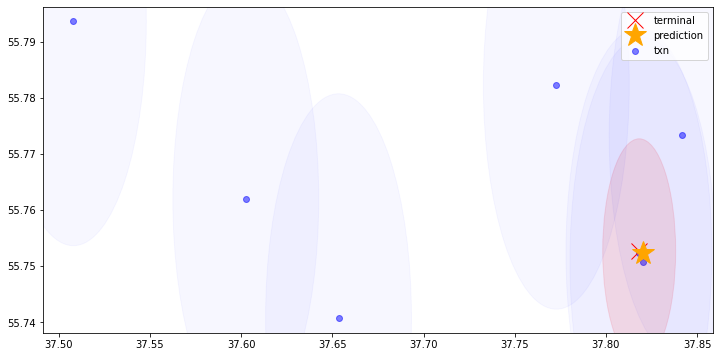

In [15]:
study_case(id_merch=644)

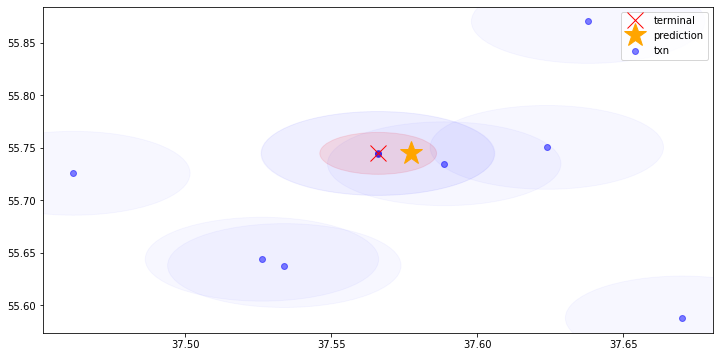

In [16]:
study_case(id_merch=2654)

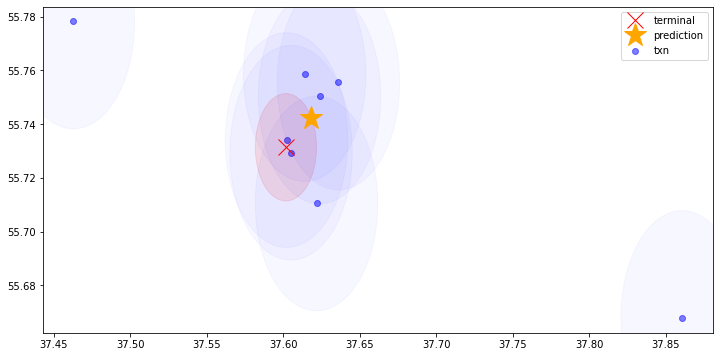

In [17]:
study_case(id_merch=1531)

### Submission

In [18]:
def to_lon_lat(coords):
    return pd.Series({'LON': coords[0], 'LAT': coords[1]})

submission_df = txn_df[
    txn_df.ID_MERCH.isin(test_df.ID_MERCH)
].groupby('ID_MERCH').apply(lambda x: to_lon_lat(find_merchant(x))).reset_index()

In [19]:
submission_df.head()

,ID_MERCH,LON,LAT
0,4286,37.469997,55.822613
1,4287,37.517629,55.676606
2,4288,37.571413,55.709198
3,4289,37.565406,55.545858
4,4290,30.353169,59.853350


In [20]:
submission_df.to_csv('submission.csv', index=None)